In [2]:
import pandas as pd
import numpy as np

In [24]:
def interval_score(lower, upper, true, alpha):
  score = upper-lower
  if true<lower:
    score += 2/alpha*(lower-true)
  if true>upper:
    score += 2/alpha*(true-upper)
  return score

### DNN

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

In [78]:
## change here the model you want to load 
new_model = tf.keras.models.load_model('./models/model_severity_test.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 25)               100       
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 64)                1664      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dropout_17 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                      

In [79]:
from sklearn.metrics import classification_report
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE

## change here the data you want to load 

data_load = np.load('./data/test_data.npy')
label_load = np.load('./data/severity_test_label.npy')

pred = new_model.predict(data_load).astype('float32')
rmse = np.sqrt(MSE(label_load, pred))
print("RMSE : % f" %(rmse))

print("MAE: % f" %(mean_absolute_error(label_load,pred)))


from sklearn.metrics import r2_score
print('R2 score: %f' % (r2_score(label_load, pred)))


RMSE :  17.329976
MAE:  9.863532
R2 score: 0.077980


In [80]:
y_test=label_load
stdev = np.sqrt(sum((np.reshape(new_model.predict(data_load),(len(y_test))) - y_test)**2) / (len(y_test) - 2))
# stdev = np.sqrt(sum((np.reshape(new_model.predict(np.asarray(test_data).astype('float32')),(len(y_test))) - y_test)**2) / (len(y_test) - 2))

print(stdev)
correct = 0
score = 0
for i in range(len(y_test)):
  if y_test[i] >= (pred[i] - 1.15*stdev) and y_test[i]<= (pred[i] + 1.15*stdev):
    correct += 1
  score += interval_score(pred[i] - 1.15*stdev, pred[i]+1.15*stdev, y_test[i], 0.75)
print("With 75% prediction interval, accuracy is: ", (correct/len(y_test)), 'Interval score is: ', score/len(y_test)) 

correct = 0
score = 0
for i in range(len(y_test)):
  if y_test[i] >= (pred[i] - 1.64*stdev) and y_test[i]<= (pred[i] + 1.64*stdev):
    correct += 1
  score += interval_score(pred[i] - 1.64*stdev, pred[i]+1.64*stdev, y_test[i], 0.90)
print("With 90% prediction interval, accuracy is: ", (correct/len(y_test)), 'Interval score is: ',score/len(y_test) ) 
correct = 0
score = 0
for i in range(len(y_test)):
  if y_test[i] >= (pred[i] - 1.96*stdev) and y_test[i]<= (pred[i] + 1.96*stdev):
    correct += 1
  score += interval_score(pred[i] - 1.96*stdev, pred[i]+1.96*stdev, y_test[i], 0.95)
print("With 95% prediction interval, accuracy is: ", (correct/len(y_test)), 'Interval score is: ', score/len(y_test)) 

17.687332595340358
With 75% prediction interval, accuracy is:  0.92 Interval score is:  [47.15487]
With 90% prediction interval, accuracy is:  0.94 Interval score is:  [62.16594]
With 95% prediction interval, accuracy is:  0.94 Interval score is:  [72.552376]


Text(0, 0.5, 'Severity')

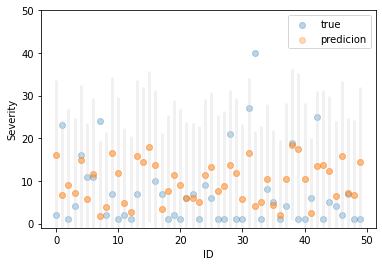

In [82]:
import matplotlib.pyplot as plt

x=range(len(y_test))
scatter = plt.scatter(x, y_test,  alpha=0.3,
            cmap='viridis', label = 'true')
plt.errorbar(x, pred, yerr=stdev, fmt='o', color='#ff7f0e', alpha=0.3,
             ecolor='lightgray', elinewidth=3, capsize=0)
scatter = plt.scatter(x, pred,  alpha=0.3,
            cmap='viridis', label = 'predicion')
# plt.colorbar();  # show color scale
plt.legend()
plt.ylim((-1,50))
plt.xlabel('ID')
plt.ylabel('Severity')

In [77]:
## change here the variable name to match the label and data you loaded
results_b_test = []
for t in np.linspace(1.15*stdev,2.58*stdev,10):
  correct = 0
  for i in range(len(y_test)):
    if abs(y_test[i]-pred[i])<t:
      correct += 1
  print(correct/len(y_test))
  results_b_test.append(correct/len(y_test))

0.92
0.94
0.94
0.94
0.94
0.94
0.96
0.96
0.96
0.96


(85.0, 109.0)

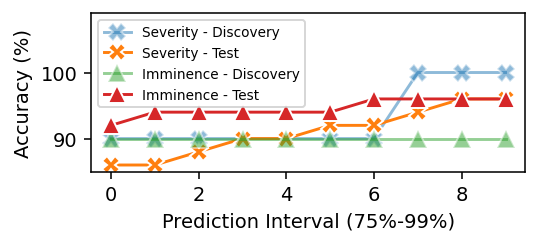

In [ ]:
## make sure you plot after you have all data ready: results_s_dis, results_s, results_b_dis,results_b
fig,ax = plt.subplots(figsize=(4,1.5),dpi = 140)
plt.plot([value*100 for value in results_s_dis], label = 'Severity - Discovery', marker = 'X', markeredgecolor = 'white',ms =9, alpha = 0.5)
plt.plot([value*100 for value in results_s], label = 'Severity - Test', marker = 'X', markeredgecolor = 'white',ms =9)
plt.plot([value*100 for value in results_b_dis], label = 'Imminence - Discovery',marker = '^', markeredgecolor = 'white',ms =9,alpha = 0.5)
plt.plot([value*100 for value in results_b], label = 'Imminence - Test',marker = '^', markeredgecolor = 'white',ms =9)
plt.xlabel('Prediction Interval (75%-99%)')
plt.ylabel('Accuracy (%)')
plt.legend(ncol=1,prop={'size': 7})
plt.ylim((85,109))

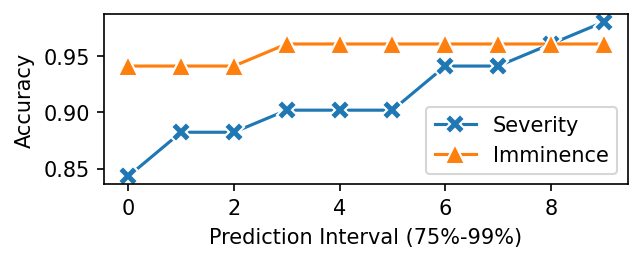

In [ ]:
fig,ax = plt.subplots(figsize=(4.5,1.5),dpi = 150)
plt.plot(results_s, label = 'Severity', marker = 'X', markeredgecolor = 'white',ms =10)
plt.plot(results_b, label = 'Imminence',marker = '^', markeredgecolor = 'white',ms =10)
plt.xlabel('Prediction Interval (75%-99%)')
plt.ylabel('Accuracy')
plt.legend()